In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'coldplay-lyrics-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5376245%2F8936089%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240718%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240718T113913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4da46df5b4ad47e4c5bae4cdafa25849a693733bdc1c2ba17077dccfbce3f94e67ec563faedbfc3c553252fad6a6e2f22d142300f70be5badb3948cb92141d9769ba8264e461d29ce6b41e5f7acd96af77e94bf7bfa8678d9d5d50d29e76e837c76965bbf30664bf4f9edd84b60e5322fb320d0b96e150cebd42065a9c3a2babf8b5d85096f433cb3dce885cdc2db50937cc4ce1b54044c262095eedcf67c0b570d87fc8f2a58ac4de8ede8961a9869a1de4bd21b6db0358ee2701cf09f527b799d032891db10e4141eef7b39f405bb93dc6ce4d48fd9c576270848fa30a6fbececc9fd5a2ceeedbb6eb657db9ef54d7cffbf20f930bb42b60c22c8d14ed209a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 44044 bytes downloaded
Downloaded and uncompressed: coldplay-lyrics-dataset
Data source import complete.


# Sentiment Analysis Comparison for Coldplay Lyrics

This notebook performs sentiment analysis on Coldplay song lyrics using multiple models and compares their results.

In [2]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [3]:
# Import required libraries
import pandas as pd
from transformers import pipeline, AutoTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import logging
import torch

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## 1. Data Loading and Preprocessing

In [43]:
logging.info("Step 1: Data Loading and Preprocessing")
try:
    df = pd.read_excel('Coldplay Research Project_Data.xlsx')
    logging.info(f"Dataset loaded successfully. Shape: {df.shape}")
except Exception as e:
    logging.error(f"Error loading dataset: {e}")
    raise

# Preprocess the text data
df['lyrics_clean'] = df['Lyrics'].str.lower().str.replace(r'[^\w\s]', '')

# Display the first few rows of the dataframe
df.head()

,#,Album Number,Album Name,Album Release Date,Track Number,Track Name,Lyrics,lyrics_clean
0,1,1,Parachutes,2000,1,Don't Panic,"Bones, sinking like stones\nAll that we fought...","bones, sinking like stones\nall that we fought..."
1,2,1,Parachutes,2000,2,Shiver,So I look in your direction\nBut you pay me no...,so i look in your direction\nbut you pay me no...
2,3,1,Parachutes,2000,3,Spies,"I awake to find no peace of mind\nI said, ""How...","i awake to find no peace of mind\ni said, ""how..."
3,4,1,Parachutes,2000,4,Sparks,Did I drive you away?\nI know what you'll say\...,did i drive you away?\ni know what you'll say\...
4,5,1,Parachutes,2000,5,Yellow,Look at the stars\nLook how they shine for you...,look at the stars\nlook how they shine for you...


## 2. Model Initialization

In [7]:
logging.info("Step 2: Model Initialization")
# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
logging.info(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Initialize sentiment analysis pipelines and tokenizers for different models
models = {}
tokenizers = {}
model_configs = [
    ('siebert/sentiment-roberta-large-english', 'sentiment-analysis'),
    ('cardiffnlp/twitter-roberta-base-sentiment', 'sentiment-analysis'),
    ('jialicheng/electra-base-imdb', 'sentiment-analysis'),
    ('textattack/albert-base-v2-SST-2', 'sentiment-analysis'),
    ('dipawidia/xlnet-base-cased-product-review-sentiment-analysis', 'sentiment-analysis'),
    ('nlptown/bert-base-multilingual-uncased-sentiment', 'sentiment-analysis'),
    ('distilbert-base-uncased-finetuned-sst-2-english', 'sentiment-analysis')
]

for model_name, task in model_configs:
    try:
        models[model_name] = pipeline(task, model=model_name, device=device)
        tokenizers[model_name] = AutoTokenizer.from_pretrained(model_name)
    except torch.cuda.OutOfMemoryError:
        logging.warning(f"GPU out of memory for {model_name}. Falling back to CPU.")
        models[model_name] = pipeline(task, model=model_name, device=-1)
        tokenizers[model_name] = AutoTokenizer.from_pretrained(model_name)

# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

print("Models initialized:")
for model_name in models.keys():
    print(f"- {model_name}")
print("- VADER")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/317 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Models initialized:
- siebert/sentiment-roberta-large-english
- cardiffnlp/twitter-roberta-base-sentiment
- jialicheng/electra-base-imdb
- textattack/albert-base-v2-SST-2
- dipawidia/xlnet-base-cased-product-review-sentiment-analysis
- nlptown/bert-base-multilingual-uncased-sentiment
- distilbert-base-uncased-finetuned-sst-2-english
- VADER


## 3. Sentiment Analysis Functions

In [50]:
logging.info("Step 3: Sentiment Analysis")
# Function to get VADER sentiment
def get_vader_sentiment(text):
    return vader.polarity_scores(text)['compound']

import torch

import torch

def get_transformer_sentiment(model_pipeline, tokenizer, text):
    try:
        # Check if the input is a string
        if not isinstance(text, str):
            logging.warning(f"Input is not a string. Type: {type(text)}. Attempting to convert.")
            text = str(text)

        # Tokenize the text
        encoded_input = tokenizer(text, truncation=True, padding=True, max_length=510, return_tensors='pt')

        # Pass the encoded input to the model pipeline
        with torch.no_grad():  # Disable gradient calculation
            outputs = model_pipeline.model(**encoded_input)

        # Process the output
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

        # Map the predicted class to a label (adjust this based on your model's output)
        label_map = {0: "NEGATIVE", 1: "POSITIVE"}  # Adjust this mapping as needed
        predicted_label = label_map.get(predicted_class, "UNKNOWN")

        # Extract the probability of positive sentiment
        positive_probability = probabilities[0][1].item()

        return predicted_label, confidence, positive_probability

    except Exception as e:
        logging.error(f"Error in sentiment analysis: {e}")
        return "ERROR", 0.0


# Function to calculate average sentiment score
def calculate_average_confidence(df, model_name):
    return df[f'{model_name}_confidence'].mean()

## 4. Apply Sentiment Analysis

In [51]:
for model_name, model_pipeline in tqdm(models.items(), desc="Analyzing sentiments"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    df[f'{model_name}_sentiment'], df[f'{model_name}_confidence'],df[f'{model_name}_pos_prob'] = zip(*df['lyrics_clean'].apply(lambda x: get_transformer_sentiment(model_pipeline, tokenizer, x)))
    avg_confidence = calculate_average_confidence(df, model_name)
    logging.info(f"Average sentiment for {model_name}: {avg_confidence:.4f}")

# Apply VADER to the dataset
df['vader_sentiment'] = df['lyrics_clean'].apply(get_vader_sentiment)
vader_avg = df['vader_sentiment'].mean()
logging.info(f"Average VADER sentiment: {vader_avg:.4f}")

# Display the first few rows of the dataframe with sentiment scores
df.head()

Analyzing sentiments: 100%|██████████| 7/7 [17:57<00:00, 153.95s/it]


,#,Album Number,Album Name,Album Release Date,Track Number,Track Name,Lyrics,lyrics_clean,siebert/sentiment-roberta-large-english_sentiment,siebert/sentiment-roberta-large-english_confidence,...,dipawidia/xlnet-base-cased-product-review-sentiment-analysis_sentiment,dipawidia/xlnet-base-cased-product-review-sentiment-analysis_confidence,dipawidia/xlnet-base-cased-product-review-sentiment-analysis_pos_prob,nlptown/bert-base-multilingual-uncased-sentiment_sentiment,nlptown/bert-base-multilingual-uncased-sentiment_confidence,nlptown/bert-base-multilingual-uncased-sentiment_pos_prob,distilbert-base-uncased-finetuned-sst-2-english_sentiment,distilbert-base-uncased-finetuned-sst-2-english_confidence,distilbert-base-uncased-finetuned-sst-2-english_pos_prob,vader_sentiment
0,1,1,Parachutes,2000,1,Don't Panic,"Bones, sinking like stones\nAll that we fought...","bones, sinking like stones\nall that we fought...",POSITIVE,0.998601,...,POSITIVE,0.940896,0.940896,UNKNOWN,0.394497,0.122008,POSITIVE,0.992505,0.992505,0.9892
1,2,1,Parachutes,2000,2,Shiver,So I look in your direction\nBut you pay me no...,so i look in your direction\nbut you pay me no...,NEGATIVE,0.997033,...,NEGATIVE,0.919406,0.080594,UNKNOWN,0.422107,0.102932,NEGATIVE,0.944115,0.055885,0.9929
2,3,1,Parachutes,2000,3,Spies,"I awake to find no peace of mind\nI said, ""How...","i awake to find no peace of mind\ni said, ""how...",NEGATIVE,0.995205,...,NEGATIVE,0.992128,0.007872,NEGATIVE,0.483644,0.220040,POSITIVE,0.967765,0.967765,0.2036
3,4,1,Parachutes,2000,4,Sparks,Did I drive you away?\nI know what you'll say\...,did i drive you away?\ni know what you'll say\...,POSITIVE,0.997974,...,NEGATIVE,0.763367,0.236633,UNKNOWN,0.315138,0.144586,POSITIVE,0.999466,0.999466,0.9761
4,5,1,Parachutes,2000,5,Yellow,Look at the stars\nLook how they shine for you...,look at the stars\nlook how they shine for you...,POSITIVE,0.996239,...,NEGATIVE,0.678520,0.321479,UNKNOWN,0.399331,0.112874,POSITIVE,0.999030,0.999030,0.9766


In [32]:
# Drop only columns ending with 'normalized_score'
#df = df.loc[:, ~df.columns.str.endswith('normalized_score')]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 30 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   #                                                                        106 non-null    int64  
 1   Album Number                                                             106 non-null    int64  
 2   Album Name                                                               106 non-null    object 
 3   Album Release Date                                                       106 non-null    int64  
 4   Track Number                                                             106 non-null    int64  
 5   Track Name                                                               106 non-null    object 
 6   Lyrics                                                                   1

In [53]:
df.describe()

,#,Album Number,Album Release Date,Track Number,siebert/sentiment-roberta-large-english_confidence,siebert/sentiment-roberta-large-english_pos_prob,cardiffnlp/twitter-roberta-base-sentiment_confidence,cardiffnlp/twitter-roberta-base-sentiment_pos_prob,jialicheng/electra-base-imdb_confidence,jialicheng/electra-base-imdb_pos_prob,textattack/albert-base-v2-SST-2_confidence,textattack/albert-base-v2-SST-2_pos_prob,dipawidia/xlnet-base-cased-product-review-sentiment-analysis_confidence,dipawidia/xlnet-base-cased-product-review-sentiment-analysis_pos_prob,nlptown/bert-base-multilingual-uncased-sentiment_confidence,nlptown/bert-base-multilingual-uncased-sentiment_pos_prob,distilbert-base-uncased-finetuned-sst-2-english_confidence,distilbert-base-uncased-finetuned-sst-2-english_pos_prob,vader_sentiment
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,53.500000,5.169811,2011.018868,6.575472,0.988687,0.735326,0.602063,0.515913,0.984410,0.761860,0.841789,0.479129,0.869938,0.300934,0.430263,0.146709,0.960122,0.498545,0.333318
std,30.743563,2.594763,6.996572,3.733881,0.042852,0.432459,0.103545,0.153745,0.062379,0.414192,0.148152,0.373419,0.133596,0.340589,0.136854,0.075122,0.081541,0.469441,0.747665
min,1.000000,1.000000,2000.000000,1.000000,0.586110,0.000916,0.433458,0.068597,0.641844,0.000099,0.505504,0.007955,0.510750,0.004150,0.231863,0.004465,0.561144,0.000776,-0.997300
25%,27.250000,3.000000,2005.000000,3.250000,0.991066,0.112500,0.515096,0.433996,0.998617,0.730687,0.772145,0.095701,0.788592,0.032202,0.321026,0.096289,0.971690,0.012265,-0.292700
50%,53.500000,5.000000,2011.000000,6.000000,0.995863,0.992837,0.586930,0.516065,0.999445,0.999220,0.912055,0.428056,0.921647,0.110676,0.398430,0.132659,0.989832,0.440770,0.785600
75%,79.750000,8.000000,2019.000000,9.000000,0.997790,0.997534,0.660550,0.617725,0.999623,0.999602,0.961104,0.912340,0.971097,0.605823,0.477818,0.209055,0.996469,0.991099,0.968850
max,106.000000,9.000000,2021.000000,16.000000,0.999084,0.998839,0.927219,0.829474,0.999901,0.999718,0.996992,0.996992,0.999516,0.999516,0.861618,0.369105,0.999771,0.999771,0.999800


In [54]:
#df.to_csv('sentiment_analysis_results_final.csv', index=False)

In [55]:
df.columns

Index(['#', 'Album Number', 'Album Name', 'Album Release Date', 'Track Number',
       'Track Name', 'Lyrics', 'lyrics_clean',
       'siebert/sentiment-roberta-large-english_sentiment',
       'siebert/sentiment-roberta-large-english_confidence',
       'siebert/sentiment-roberta-large-english_pos_prob',
       'cardiffnlp/twitter-roberta-base-sentiment_sentiment',
       'cardiffnlp/twitter-roberta-base-sentiment_confidence',
       'cardiffnlp/twitter-roberta-base-sentiment_pos_prob',
       'jialicheng/electra-base-imdb_sentiment',
       'jialicheng/electra-base-imdb_confidence',
       'jialicheng/electra-base-imdb_pos_prob',
       'textattack/albert-base-v2-SST-2_sentiment',
       'textattack/albert-base-v2-SST-2_confidence',
       'textattack/albert-base-v2-SST-2_pos_prob',
       'dipawidia/xlnet-base-cased-product-review-sentiment-analysis_sentiment',
       'dipawidia/xlnet-base-cased-product-review-sentiment-analysis_confidence',
       'dipawidia/xlnet-base-cased-produc

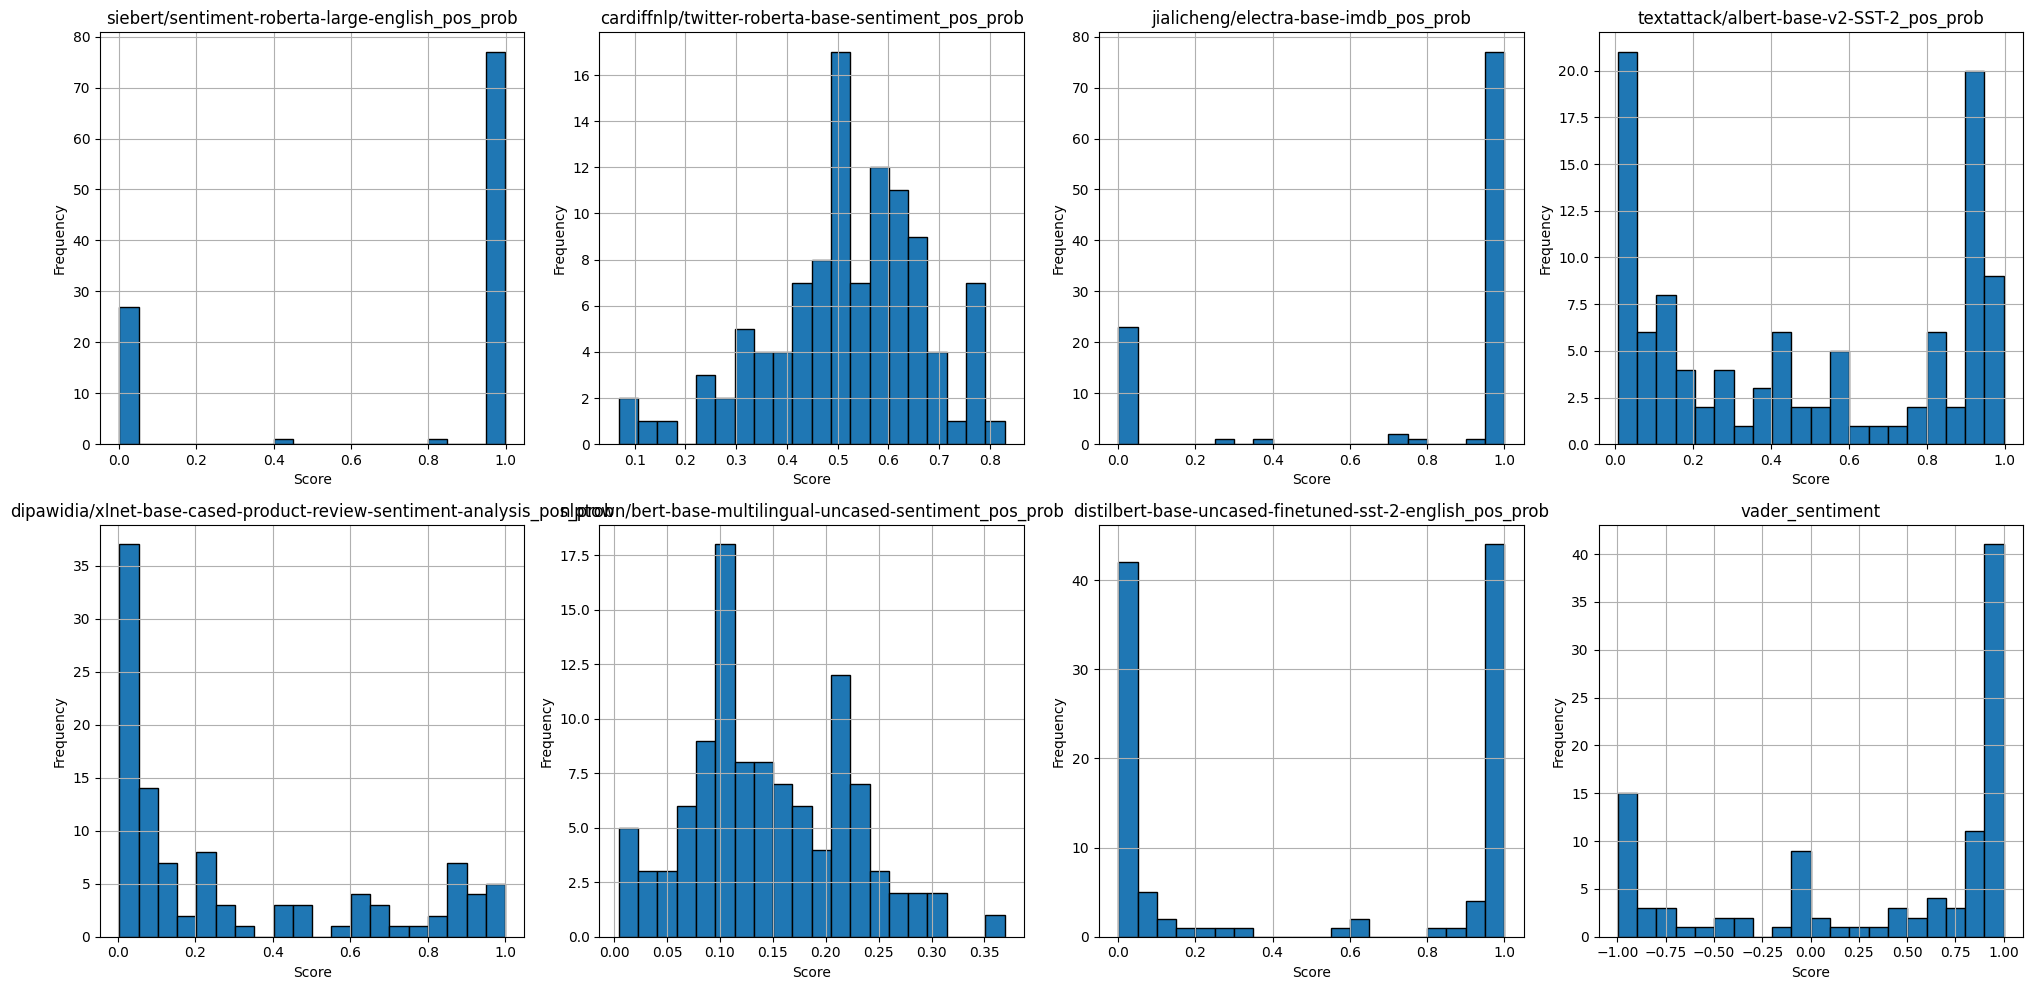

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation (assumes df is already created and normalized from previous steps)

# List of sentiment score columns
sentiment_columns = [
    'siebert/sentiment-roberta-large-english_pos_prob',
    'cardiffnlp/twitter-roberta-base-sentiment_pos_prob',
    'jialicheng/electra-base-imdb_pos_prob',
    'textattack/albert-base-v2-SST-2_pos_prob',
    'dipawidia/xlnet-base-cased-product-review-sentiment-analysis_pos_prob',
    'nlptown/bert-base-multilingual-uncased-sentiment_pos_prob',
    'distilbert-base-uncased-finetuned-sst-2-english_pos_prob',
    'vader_sentiment'
]

# Plot histograms for each sentiment score
plt.figure(figsize=(20, 10))

for i, column in enumerate(sentiment_columns, 1):
    plt.subplot(2, 4, i)
    df[column].hist(bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [58]:
df[['cardiffnlp/twitter-roberta-base-sentiment_confidence', 'cardiffnlp/twitter-roberta-base-sentiment_sentiment','cardiffnlp/twitter-roberta-base-sentiment_pos_prob']]

,cardiffnlp/twitter-roberta-base-sentiment_confidence,cardiffnlp/twitter-roberta-base-sentiment_sentiment,cardiffnlp/twitter-roberta-base-sentiment_pos_prob
0,0.750086,UNKNOWN,0.229562
1,0.641143,POSITIVE,0.641143
2,0.524499,NEGATIVE,0.416890
3,0.582314,POSITIVE,0.582314
4,0.601301,UNKNOWN,0.362714
...,...,...,...
101,0.927219,UNKNOWN,0.068597
102,0.485811,POSITIVE,0.485811
103,0.555396,UNKNOWN,0.418709
104,0.787518,POSITIVE,0.787518


In [40]:
df['cardiffnlp/twitter-roberta-base-sentiment_sentiment'].value_counts()

cardiffnlp/twitter-roberta-base-sentiment_sentiment
POSITIVE    76
NEGATIVE    16
UNKNOWN     14
Name: count, dtype: int64

In [63]:
df.groupby(by='cardiffnlp/twitter-roberta-base-sentiment_sentiment')['cardiffnlp/twitter-roberta-base-sentiment_pos_prob'].max()

cardiffnlp/twitter-roberta-base-sentiment_sentiment
NEGATIVE    0.444220
POSITIVE    0.829474
UNKNOWN     0.452110
Name: cardiffnlp/twitter-roberta-base-sentiment_pos_prob, dtype: float64

In [64]:
df['cardiffnlp/twitter-roberta-base-sentiment_confidence'].mean()

0.6020633361811908

## 5. Results Processing

## 6. Visualization

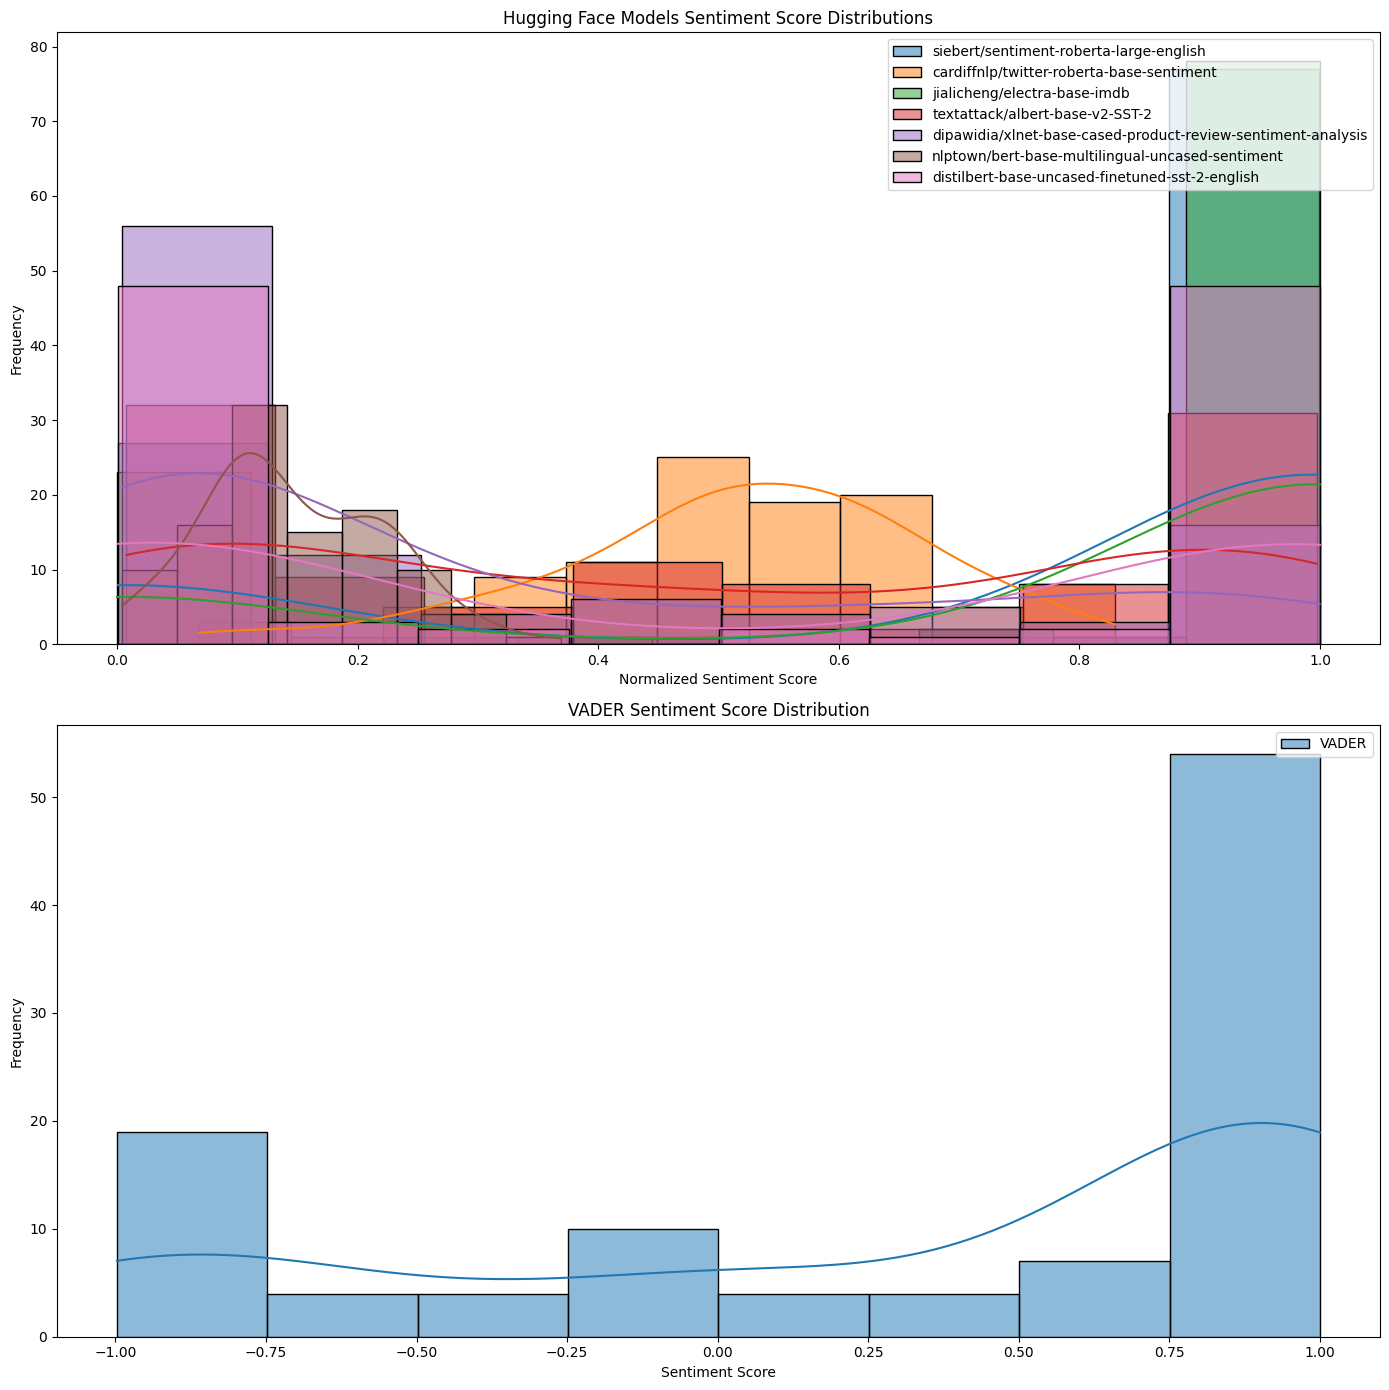

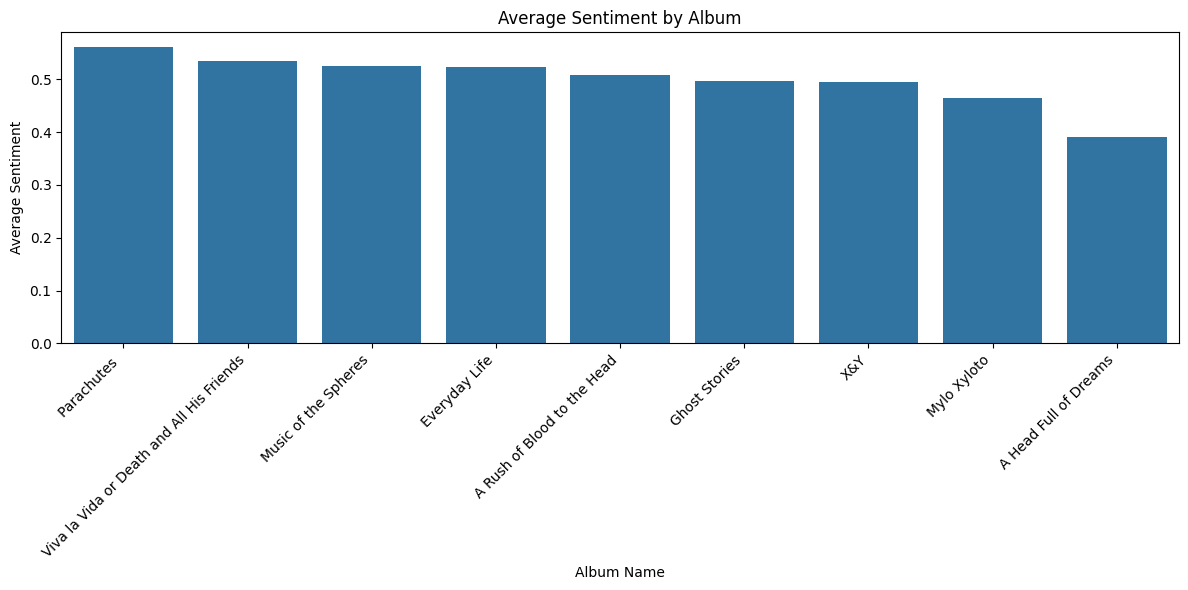

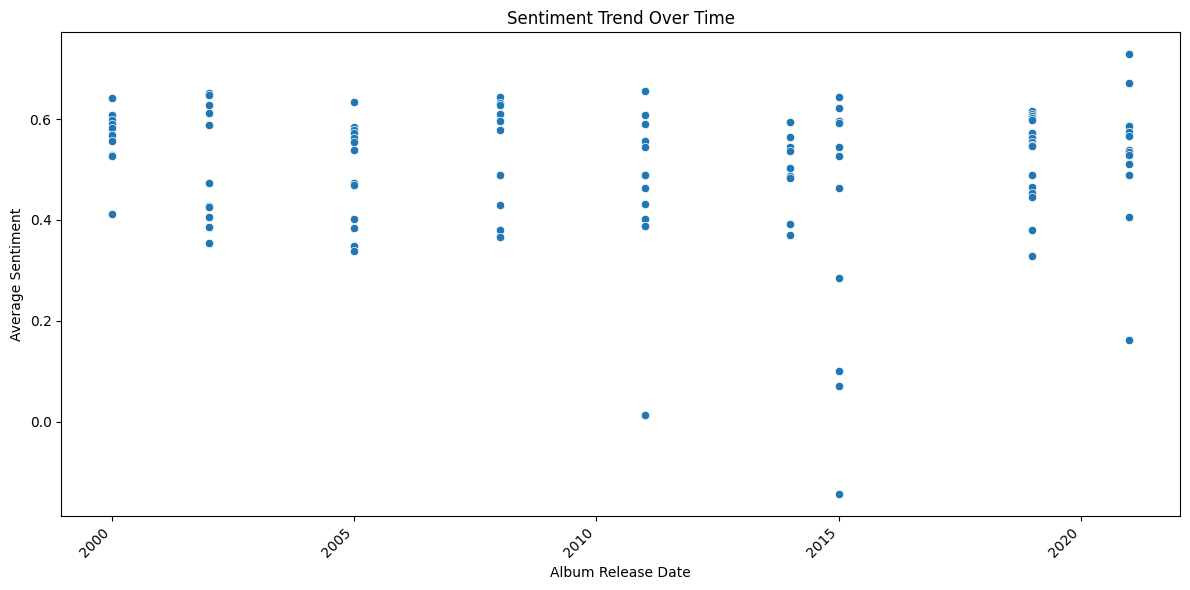

In [65]:
# Create plots to visualize the sentiment distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# Plot for Hugging Face models
for model_name in models.keys():
    sns.histplot(data=df, x=f'{model_name}_pos_prob', kde=True, ax=ax1, label=model_name, alpha=0.5)
ax1.legend(loc='upper right')
ax1.set_title('Hugging Face Models Sentiment Score Distributions')
ax1.set_xlabel('Normalized Sentiment Score')
ax1.set_ylabel('Frequency')

# Plot for VADER
sns.histplot(data=df, x='vader_sentiment', kde=True, ax=ax2, label='VADER', alpha=0.5)
ax2.legend(loc='upper right')
ax2.set_title('VADER Sentiment Score Distribution')
ax2.set_xlabel('Sentiment Score')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Visualize average sentiment by album
plt.figure(figsize=(12, 6))
sns.barplot(x=album_sentiment.index, y=album_sentiment.values)
plt.title('Average Sentiment by Album')
plt.xlabel('Album Name')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize sentiment over time
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='Album Release Date', y='Average_sentiment')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Album Release Date')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Export Results

In [ ]:
# Export the results to a CSV for further analysis
#results_df.to_csv('sentiment_analysis_results.csv', index=False)
logging.info("Results exported to sentiment_analysis_results.csv")

logging.info("Sentiment classification process completed.")

In [14]:
results_df.head()

,Track Name,Album Name,Album Release Date,siebert/sentiment-roberta-large-english_sentiment,cardiffnlp/twitter-roberta-base-sentiment_sentiment,jialicheng/electra-base-imdb_sentiment,textattack/albert-base-v2-SST-2_sentiment,dipawidia/xlnet-base-cased-product-review-sentiment-analysis_sentiment,nlptown/bert-base-multilingual-uncased-sentiment_sentiment,distilbert-base-uncased-finetuned-sst-2-english_sentiment,VADER_sentiment,Average_sentiment
101,Biutyful,Music of the Spheres,2021,-0.000320,-0.018195,0.999209,0.994606,0.997552,0.853542,0.999709,0.9998,0.728238
99,Human Heart (with We Are King & Jacob Collier),Music of the Spheres,2021,-0.002836,-0.099038,0.999420,0.979938,0.921580,0.605562,0.971436,0.9946,0.671333
45,Hurts Like Heaven,Mylo Xyloto,2011,-0.001056,-0.065597,0.999464,0.989764,0.978505,0.381342,0.998784,0.9692,0.656301
15,Daylight,A Rush of Blood to the Head,2002,-0.002266,-0.083853,0.999669,0.946408,0.803761,0.609835,0.990174,0.9460,0.651216
11,In My Place,A Rush of Blood to the Head,2002,-0.001345,-0.133924,0.997457,0.971795,0.989159,0.403720,0.998446,0.9569,0.647776


In [15]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 101 to 72
Data columns (total 12 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Track Name                                                              106 non-null    object 
 1   Album Name                                                              106 non-null    object 
 2   Album Release Date                                                      106 non-null    int64  
 3   siebert/sentiment-roberta-large-english_sentiment                       106 non-null    float64
 4   cardiffnlp/twitter-roberta-base-sentiment_sentiment                     106 non-null    float64
 5   jialicheng/electra-base-imdb_sentiment                                  106 non-null    float64
 6   textattack/albert-base-v2-SST-2_sentiment                               106 non-null  

In [16]:
results_df.describe()

,Album Release Date,siebert/sentiment-roberta-large-english_sentiment,cardiffnlp/twitter-roberta-base-sentiment_sentiment,jialicheng/electra-base-imdb_sentiment,textattack/albert-base-v2-SST-2_sentiment,dipawidia/xlnet-base-cased-product-review-sentiment-analysis_sentiment,nlptown/bert-base-multilingual-uncased-sentiment_sentiment,distilbert-base-uncased-finetuned-sst-2-english_sentiment,VADER_sentiment,Average_sentiment
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,2011.018868,-0.019265,-0.109061,0.937428,0.789509,0.740026,0.412178,0.913684,0.333318,0.499727
std,6.996572,0.062568,0.045613,0.218634,0.243161,0.268831,0.164254,0.219819,0.747665,0.139039
min,2000.000000,-0.250000,-0.250000,0.000000,0.000000,0.021499,0.000000,0.000000,-0.997300,-0.143085
25%,2005.000000,-0.002745,-0.123176,0.998482,0.688284,0.590283,0.320125,0.963293,-0.292700,0.430909
50%,2011.000000,-0.001097,-0.105444,0.999428,0.885574,0.850777,0.394957,0.988479,0.785600,0.538543
75%,2019.000000,-0.000569,-0.084862,0.999623,0.958855,0.942193,0.477818,0.996245,0.968850,0.591889
max,2021.000000,-0.000229,-0.018195,0.999901,0.996992,0.999033,0.861618,0.999771,0.999800,0.728238
